In [790]:
# Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image, ImageDraw
#import scipy as sp
import scipy.ndimage

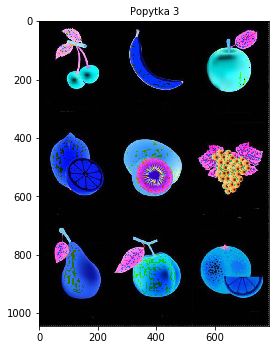

In [791]:
img = np.array(Image.open('fru.png'), dtype=np.float64)
plt.figure(figsize=(14,6))
plt.subplot(131)
plt.title('Popytka 3', fontsize=10)
plt.imshow(img)
plt.show()

In [792]:
# img = np.array(img, dtype = np.uint8)
# # from matplotlib.colors import NoNorm 
# plt.figure(figsize=(12, 8))
# # img_new= 255-img
# # plt.subplot(121)
# # plt.imshow(img_new, norm=NoNorm())

# # plt.subplot(122)
# plt.imshow(img)
# plt.show()

In [793]:
print(img)
print(img.shape)

[[[ 255.  255.  255.]
  [ 255.  255.  255.]
  [ 255.  255.  255.]
  ..., 
  [ 255.  255.  255.]
  [ 232.  232.  232.]
  [ 222.  222.  222.]]

 [[ 255.  255.  255.]
  [ 255.  255.  255.]
  [ 255.  255.  255.]
  ..., 
  [ 255.  255.  255.]
  [ 203.  203.  203.]
  [ 166.  166.  166.]]

 [[ 255.  255.  255.]
  [ 255.  255.  255.]
  [ 255.  255.  255.]
  ..., 
  [ 241.  241.  241.]
  [ 181.  181.  181.]
  [ 137.  137.  137.]]

 ..., 
 [[ 147.  147.  147.]
  [ 168.  168.  168.]
  [ 199.  199.  199.]
  ..., 
  [ 215.  215.  215.]
  [ 170.  170.  170.]
  [ 139.  139.  139.]]

 [[ 203.  203.  203.]
  [ 220.  220.  220.]
  [ 238.  238.  238.]
  ..., 
  [ 230.  230.  230.]
  [ 139.  139.  139.]
  [  70.   70.   70.]]

 [[ 248.  248.  248.]
  [ 255.  255.  255.]
  [ 255.  255.  255.]
  ..., 
  [ 251.  251.  251.]
  [ 247.  247.  247.]
  [ 248.  248.  248.]]]
(1044, 787, 3)


In [794]:
red = img[:, :, 0]
print (red.shape)

(1044, 787)


In [795]:
def approximate(red, eps): 
    n = 300
    u, s, v = np.linalg.svd(red)
    #n = -1
    img_appr = np.array(red)
    
    while np.linalg.norm(img_appr - red) / np.linalg.norm(red) < eps:
        img_appr = np.dot(u[:, :n] * s[:n], v[:n, :])
        n -= 1
    n += 2
    eps_rank = n
    img_appr = np.dot(u[:, :n] * s[:n], v[:n, :])
    return img_appr, eps_rank

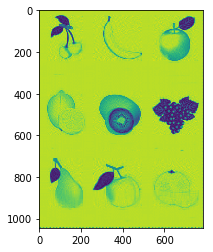

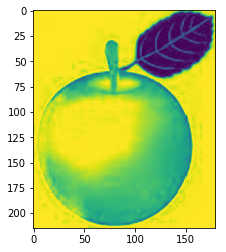

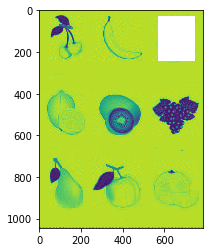

In [796]:
new_img, rank = approximate(red, 0.025)
plt.imshow(new_img)
plt.show()
cropped_img = red[30:245, 570:750]

plt.imshow(cropped_img)
plt.show()
new_img[30:245, 570:750] =np.zeros((245-30, 750-570))
plt.imshow(new_img)   
plt.show()

In [797]:
import numpy as np
import scipy.sparse.linalg as spla
import scipy.sparse as sparse

class SoftInput():
    def __init__(self, X):
        self.X = X
        self.nonzero = self.X.nonzero()
        
    def fit(self, lambdas, maxiter, tol=1e-7, start_rank=700):
        self.rank = start_rank
        self.tol = tol
        self.lambdas = np.sort(lambdas)[::-1]
        self.Z_old = sparse.csr_matrix(self.X.shape)
        self.S_old = np.zeros((self.rank,))
        self.U_old = np.zeros((self.X.shape[0], self.rank))
        self.Vt_old = np.zeros((self.rank, self.X.shape[1]))
        
        self.filled = []
        
        for l in self.lambdas:
            for i in range(maxiter):
                proj_data = np.array(self.Z_old[self.nonzero]).flatten()
                self.Z_proj = sparse.csr_matrix((proj_data, self.nonzero), shape=self.X.shape)
                lin_op = spla.LinearOperator(self.X.shape,
                                             matvec=self.matvec,
                                             rmatvec=self.rmatvec)
                U, S, Vt = spla.svds(lin_op, self.rank)
                S -= l
                S = S[S > 0]
                
                #print(S.size, S.min())
                self.rank = S.shape[0]
                U = U[:, :self.rank]
                Vt = Vt[:self.rank, :]
                self.U_old = U
                self.Vt_old = Vt
                self.S_old = S
                self.Z_new = U.dot(np.diag(S).dot(Vt))
                # TODO: compute Frobenius norm with no explicit computations of Z
                if (np.linalg.norm(self.Z_new - self.Z_old) ** 2 / np.linalg.norm(self.Z_new) ** 2 < self.tol):
                    self.Z_old = self.Z_new
                    print('converged')
                    break
                self.Z_old = self.Z_new
            self.filled.append(self.Z_old)
        
        return self.lambdas, self.filled

    def matvec(self, vec):
        res = self.X.dot(vec) - self.Z_proj.dot(vec)
        res += self.U_old.dot(np.diag(self.S_old).dot(self.Vt_old.dot(vec)))
        return res
    
    def rmatvec(self, vec):
        res = self.X.T.dot(vec) - self.Z_proj.T.dot(vec)
        res += self.Vt_old.T.dot(np.diag(self.S_old).dot(self.U_old.T.dot(vec)))
        return res

X = sparse.csr_matrix(new_img)
soft_input = SoftInput(X)

In [798]:
lambdas = np.linspace(0, 5, 10)
lambdas, approximations = soft_input.fit(lambdas=lambdas, maxiter=10000, start_rank=rank, tol=1e-6)

ArpackError: ARPACK error 3: No shifts could be applied during a cycle of the Implicitly restarted Arnoldi iteration. One possibility is to increase the size of NCV relative to NEV. 

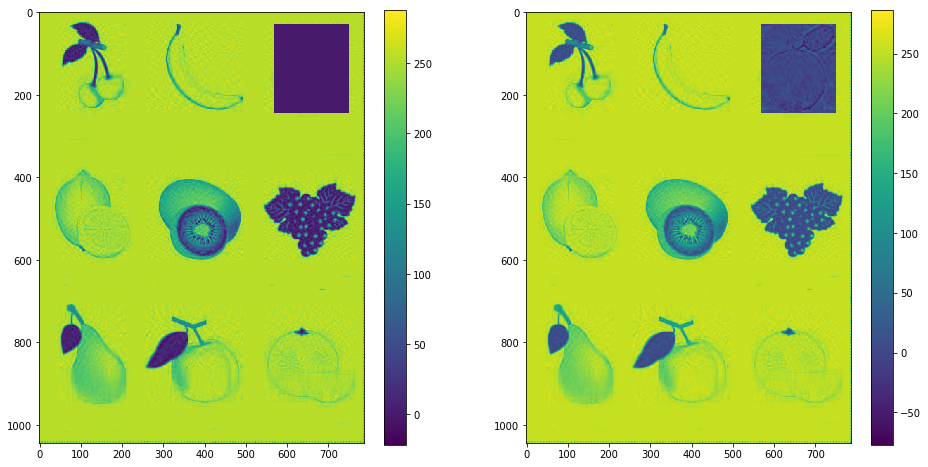

In [764]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.imshow(X.toarray())
plt.colorbar()

plt.subplot(122)
plt.imshow(approximations[-1])
plt.colorbar()
plt.show()

In [765]:
a=approximations[-1]

In [766]:
green = img[:, :, 1]
def approximate(green, eps): 
    n = 300
    u, s, v = np.linalg.svd(green)
    #n = -1
    img_appr = np.array(green)
    
    while np.linalg.norm(img_appr - green) / np.linalg.norm(green) < eps:
        img_appr = np.dot(u[:, :n] * s[:n], v[:n, :])
        n -= 1
    n += 2
    eps_rank = n
    img_appr = np.dot(u[:, :n] * s[:n], v[:n, :])
    return img_appr, eps_rank



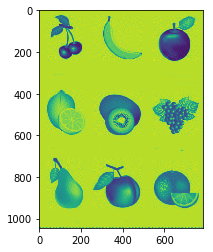

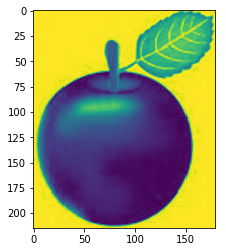

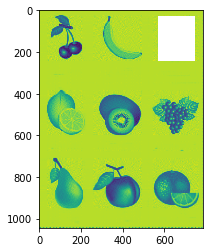

In [788]:
new_img_1, rank = approximate(green, 0.025)
plt.imshow(new_img_1)
plt.show()
cropped_img = green[30:245, 570:750]

plt.imshow(cropped_img)
plt.show()
new_img_1[30:245, 570:750] =np.zeros((245-30, 750-570))
plt.imshow(new_img_1)
plt.show()

In [768]:
import numpy as np
import scipy.sparse.linalg as spla
import scipy.sparse as sparse

class SoftInput():
    def __init__(self, X):
        self.X = X
        self.nonzero = self.X.nonzero()
        
    def fit(self, lambdas, maxiter, tol=1e-7, start_rank=700):
        self.rank = start_rank
        self.tol = tol
        self.lambdas = np.sort(lambdas)[::-1]
        self.Z_old = sparse.csr_matrix(self.X.shape)
        self.S_old = np.zeros((self.rank,))
        self.U_old = np.zeros((self.X.shape[0], self.rank))
        self.Vt_old = np.zeros((self.rank, self.X.shape[1]))
        
        self.filled = []
        
        for l in self.lambdas:
            for i in range(maxiter):
                proj_data = np.array(self.Z_old[self.nonzero]).flatten()
                self.Z_proj = sparse.csr_matrix((proj_data, self.nonzero), shape=self.X.shape)
                lin_op = spla.LinearOperator(self.X.shape,
                                             matvec=self.matvec,
                                             rmatvec=self.rmatvec)
                U, S, Vt = spla.svds(lin_op, self.rank)
                S -= l
                S = S[S > 0]
                
                #print(S.size, S.min())
                self.rank = S.shape[0]
                U = U[:, :self.rank]
                Vt = Vt[:self.rank, :]
                self.U_old = U
                self.Vt_old = Vt
                self.S_old = S
                self.Z_new = U.dot(np.diag(S).dot(Vt))
                # TODO: compute Frobenius norm with no explicit computations of Z
                if (np.linalg.norm(self.Z_new - self.Z_old) ** 2 / np.linalg.norm(self.Z_new) ** 2 < self.tol):
                    self.Z_old = self.Z_new
                    print('converged')
                    break
                self.Z_old = self.Z_new
            self.filled.append(self.Z_old)
        
        return self.lambdas, self.filled

    def matvec(self, vec):
        res = self.X.dot(vec) - self.Z_proj.dot(vec)
        res += self.U_old.dot(np.diag(self.S_old).dot(self.Vt_old.dot(vec)))
        return res
    
    def rmatvec(self, vec):
        res = self.X.T.dot(vec) - self.Z_proj.T.dot(vec)
        res += self.Vt_old.T.dot(np.diag(self.S_old).dot(self.U_old.T.dot(vec)))
        return res

X = sparse.csr_matrix(new_img_1)
soft_input = SoftInput(X)

In [769]:
lambdas = np.linspace(0, 5, 10)
lambdas, approximations = soft_input.fit(lambdas=lambdas, maxiter=10000, start_rank=rank, tol=1e-6)

converged
converged
converged
converged
converged
converged
converged
converged
converged
converged


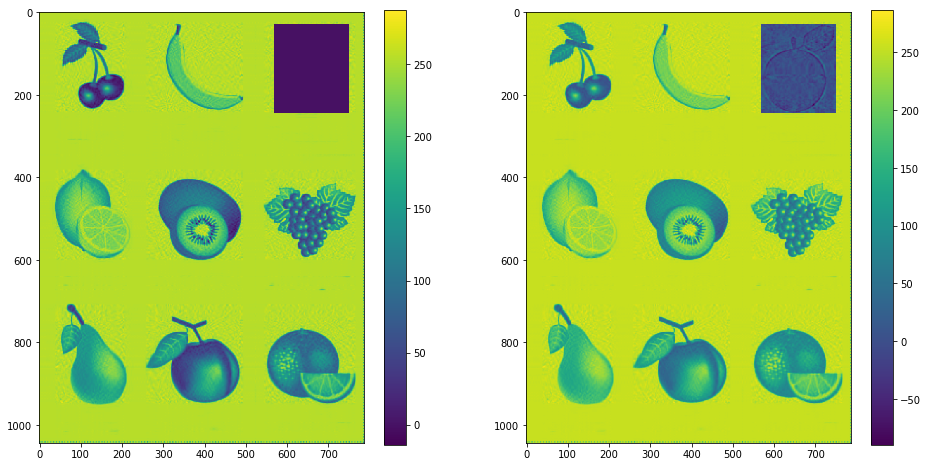

In [770]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.imshow(X.toarray())
plt.colorbar()

plt.subplot(122)
plt.imshow(approximations[-2])
plt.colorbar()
plt.show()

In [771]:
b=approximations[-2]

In [772]:
blue = img[:, :, 2]

In [773]:
def approximate(blue, eps): 
    n = 300
    u, s, v = np.linalg.svd(blue)
    #n = -1
    img_appr = np.array(blue)
    
    while np.linalg.norm(img_appr - blue) / np.linalg.norm(blue) < eps:
        img_appr = np.dot(u[:, :n] * s[:n], v[:n, :])
        n -= 1
    n += 2
    eps_rank = n
    img_appr = np.dot(u[:, :n] * s[:n], v[:n, :])
    return img_appr, eps_rank

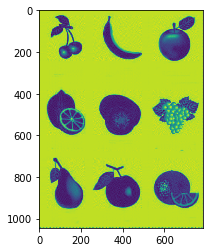

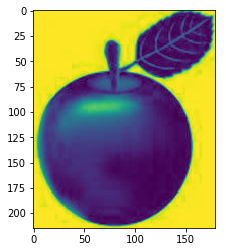

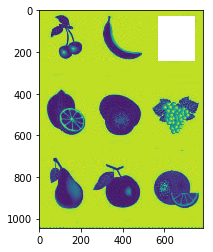

In [789]:
new_img_2, rank = approximate(blue, 0.025)
plt.imshow(new_img_2)
plt.show()
cropped_img = blue[30:245, 570:750]

plt.imshow(cropped_img)
plt.show()
new_img_2[30:245, 570:750] =np.zeros((245-30, 750-570))
plt.imshow(new_img_2)
plt.show()

In [775]:
import numpy as np
import scipy.sparse.linalg as spla
import scipy.sparse as sparse

class SoftInput():
    def __init__(self, X):
        self.X = X
        self.nonzero = self.X.nonzero()
        
    def fit(self, lambdas, maxiter, tol=1e-7, start_rank=700):
        self.rank = start_rank
        self.tol = tol
        self.lambdas = np.sort(lambdas)[::-1]
        self.Z_old = sparse.csr_matrix(self.X.shape)
        self.S_old = np.zeros((self.rank,))
        self.U_old = np.zeros((self.X.shape[0], self.rank))
        self.Vt_old = np.zeros((self.rank, self.X.shape[1]))
        
        self.filled = []
        
        for l in self.lambdas:
            for i in range(maxiter):
                proj_data = np.array(self.Z_old[self.nonzero]).flatten()
                self.Z_proj = sparse.csr_matrix((proj_data, self.nonzero), shape=self.X.shape)
                lin_op = spla.LinearOperator(self.X.shape,
                                             matvec=self.matvec,
                                             rmatvec=self.rmatvec)
                U, S, Vt = spla.svds(lin_op, self.rank)
                S -= l
                S = S[S > 0]
                
                #print(S.size, S.min())
                self.rank = S.shape[0]
                U = U[:, :self.rank]
                Vt = Vt[:self.rank, :]
                self.U_old = U
                self.Vt_old = Vt
                self.S_old = S
                self.Z_new = U.dot(np.diag(S).dot(Vt))
                # TODO: compute Frobenius norm with no explicit computations of Z
                if (np.linalg.norm(self.Z_new - self.Z_old) ** 2 / np.linalg.norm(self.Z_new) ** 2 < self.tol):
                    self.Z_old = self.Z_new
                    print('converged')
                    break
                self.Z_old = self.Z_new
            self.filled.append(self.Z_old)
        
        return self.lambdas, self.filled

    def matvec(self, vec):
        res = self.X.dot(vec) - self.Z_proj.dot(vec)
        res += self.U_old.dot(np.diag(self.S_old).dot(self.Vt_old.dot(vec)))
        return res
    
    def rmatvec(self, vec):
        res = self.X.T.dot(vec) - self.Z_proj.T.dot(vec)
        res += self.Vt_old.T.dot(np.diag(self.S_old).dot(self.U_old.T.dot(vec)))
        return res

X = sparse.csr_matrix(new_img_2)
soft_input = SoftInput(X)

In [776]:
lambdas = np.linspace(0, 5, 10)
lambdas, approximations = soft_input.fit(lambdas=lambdas, maxiter=10000, start_rank=rank, tol=1e-6)

converged
converged
converged
converged
converged
converged
converged
converged
converged
converged


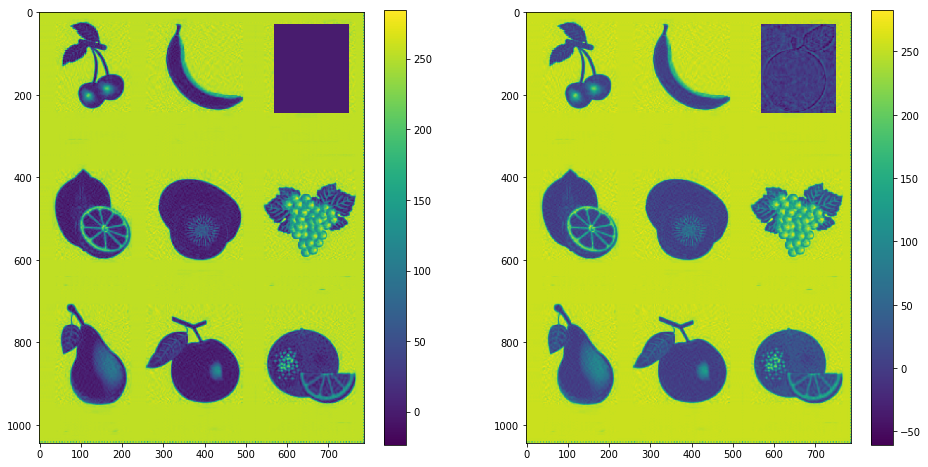

In [777]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.imshow(X.toarray())
plt.colorbar()

plt.subplot(122)
plt.imshow(approximations[-3])
plt.colorbar()
plt.show()

In [778]:
c=approximations[-3]

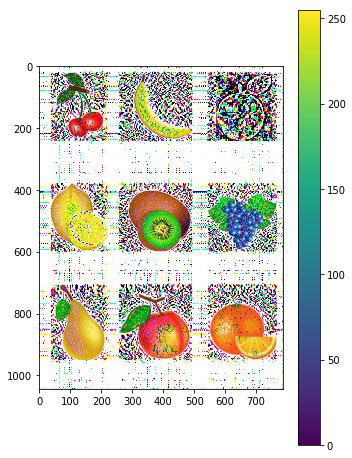

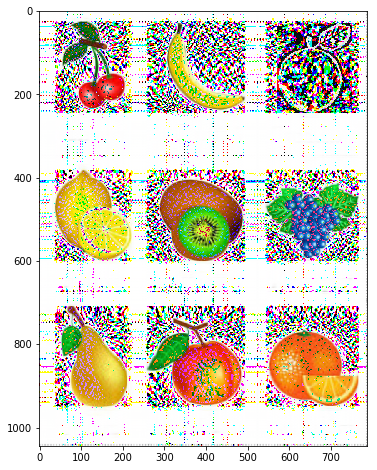

In [786]:
d=np.dstack((a,b,c))
d = np.array(d, dtype=np.uint8)
plt.figure(figsize=(12, 8))
# img_new= 255-img
plt.subplot(121)
# plt.imshow(img_new, norm=NoNorm())

# plt.subplot(122)
plt.imshow(d)
plt.colorbar()
plt.show()

from matplotlib.colors import NoNorm 
plt.figure(figsize=(12, 8))
k=np.dstack((a,b,c))
k = np.array(d, dtype=np.uint8)
plt.imshow(k, norm=NoNorm())

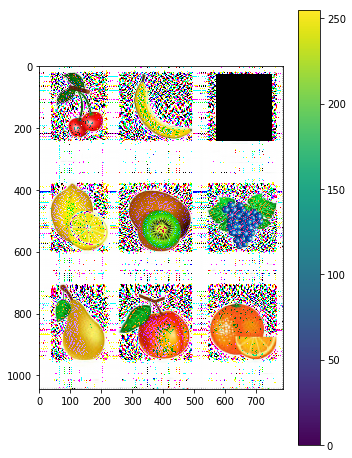

In [782]:
# f =np.array([new_img,new_img_1,new_img_2], dtype = np.uint8)
f=np.dstack((new_img,new_img_1,new_img_2))
f = np.array(f, dtype=np.uint8)
plt.figure(figsize=(12, 8))
# img_new= 255-img
plt.subplot(121)
# plt.imshow(img_new, norm=NoNorm())

# plt.subplot(122)
plt.imshow(f)
plt.colorbar()
plt.show()


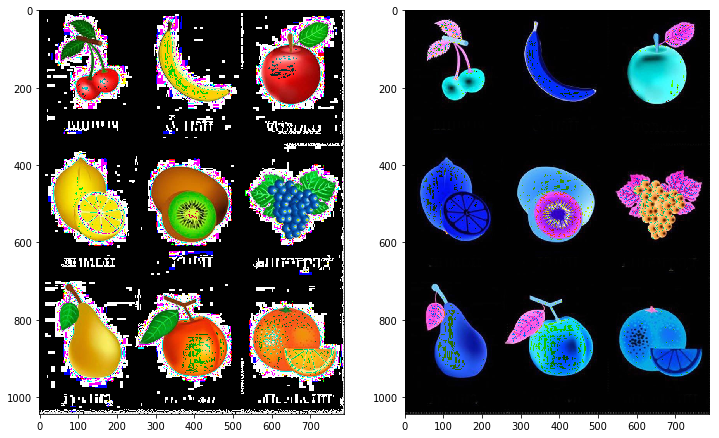

In [783]:
from matplotlib.colors import NoNorm 
plt.figure(figsize=(12, 8))
img_new= 255-img
plt.subplot(121)
plt.imshow(img_new, norm=NoNorm())

plt.subplot(122)
plt.imshow(img)
plt.show()
